In [51]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
dfOriginal = pd.read_excel("online_retail_II.xlsx", sheet_name=0)

In [3]:
df = dfOriginal.copy()


# DATA CLEANING

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
#We can see that Customer ID is missing a thousend values, we will deal with that later so we need to drop that 
df.dropna(axis=0,subset="Customer ID",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417534 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      417534 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 28.7+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,417534.000000,417534,417534.000000,417534.000000
mean,12.758815,2010-07-01 01:12:19.787609856,3.887547,15360.645478
min,-9360.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-03-26 11:26:00,1.250000,13983.000000
50%,4.000000,2010-07-08 19:12:00,1.950000,15311.000000
75%,12.000000,2010-10-14 14:08:00,3.750000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,101.220424,NaN,71.131797,1680.811316


In [7]:
# A negative quantity ? let's investigate on that
df[df["Quantity"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [8]:
# As we can see, the negative quantity only appears when Invoice have 'C' before the numbers
# The C stands for canceled, so the customer returned the product, that's why it's negative quantity 

In [9]:
canceled_prod_df = df[df["Invoice"].str.contains("^C",na=False)]
df = df.drop(canceled_prod_df.index) 
#Exclude the canceled orders 

In [10]:
canceled_prod_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [11]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,407695.000000,407695,407695.000000,407695.000000
mean,13.586686,2010-07-01 10:10:10.782177792,3.294188,15368.504107
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,13997.000000
50%,5.000000,2010-07-09 15:46:00,1.950000,15321.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16812.000000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000
std,96.842229,NaN,34.756655,1679.795700


In [12]:
#We can see that we fixed some of that, but I noticed that the minimum price is 0.0, so something was free ? 

In [13]:
df[df['Price'] == 0] #Its weird... We can see that some of the products are free but why ?
                     # In StockCode notice that not everyting have only digits, in some cases it's jut a letter or even we can see "TEST001" which is not a real customer purchase...

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231.0,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.0,15070.0,United Kingdom
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.0,18071.0,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.0,14258.0,United Kingdom
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.0,12417.0,Belgium
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.0,16858.0,United Kingdom


In [14]:
df.drop(df[df["StockCode"].str.contains("^TEST",na=False)].index, inplace=True) 
canceled_prod_df.drop(canceled_prod_df[canceled_prod_df["StockCode"].str.contains("^TEST",na=False)].index, inplace=True)

# We got it in both df... Let's get rid off that 

In [15]:
# Just assume the company gave away some products for free as marketing strategy to encourage people to become customers

In [16]:
# Lastly I want to know the total sales by each customer 

df["TotalSales"] = df["Quantity"] * df["Price"]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50


In [17]:
x = len(df)/len(dfOriginal)
r = round(x,2) * 100
print(f"We've lost around {100 - r}% of data while cleaning")

We've lost around 22.0% of data while cleaning


# FEATURE ENGINEERING

In [18]:
grouped = df.groupby(by="Customer ID").agg({"TotalSales":"sum","Invoice":"nunique","InvoiceDate":"max"})
grouped

,TotalSales,Invoice,InvoiceDate
Customer ID,,,
12346.0,169.36,2,2010-06-28 13:53:00
12347.0,1323.32,2,2010-12-07 14:57:00
12348.0,222.16,1,2010-09-27 14:59:00
12349.0,2671.14,3,2010-10-28 08:23:00
12351.0,300.93,1,2010-11-29 15:23:00
...,...,...,...
18283.0,641.77,6,2010-11-22 15:30:00
18284.0,461.68,1,2010-10-04 11:33:00
18285.0,427.00,1,2010-02-17 10:24:00


In [19]:
latest_date = grouped["InvoiceDate"].max()
grouped["RecentActivity"] = (latest_date - grouped["InvoiceDate"]).dt.days
grouped

,TotalSales,Invoice,InvoiceDate,RecentActivity
Customer ID,,,,
12346.0,169.36,2,2010-06-28 13:53:00,164
12347.0,1323.32,2,2010-12-07 14:57:00,2
12348.0,222.16,1,2010-09-27 14:59:00,73
12349.0,2671.14,3,2010-10-28 08:23:00,42
12351.0,300.93,1,2010-11-29 15:23:00,10
...,...,...,...,...
18283.0,641.77,6,2010-11-22 15:30:00,17
18284.0,461.68,1,2010-10-04 11:33:00,66
18285.0,427.00,1,2010-02-17 10:24:00,295


In [20]:
# Average activity of a user
grouped["RecentActivity"].mean() 

np.float64(90.17300556586271)

<Axes: ylabel='RecentActivity'>

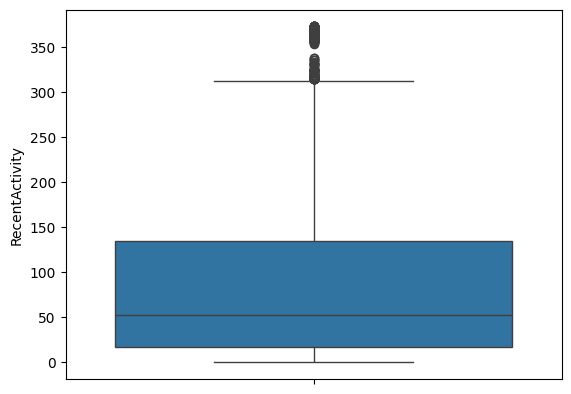

In [21]:
sns.boxplot(data=grouped["RecentActivity"])


<Axes: ylabel='TotalSales'>

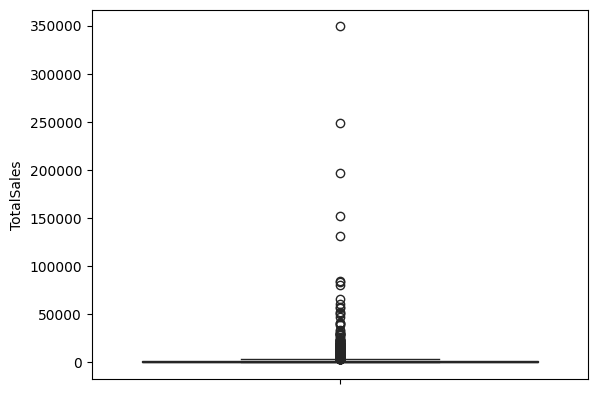

In [22]:
sns.boxplot(data=grouped["TotalSales"],color="green")

In [23]:
# the dots represent outliars, that's bad info for us 
# the problem is, that these outliars are valuable data, the are info about our customers so we can't really remove them 
    
# https://www.youtube.com/watch?v=3lQydBqWYk0&ab_channel=LearnStatisticswithBrian

In [24]:

Q1 = grouped.quantile(0.25)
Q3 = grouped.quantile(0.75)
IQR = Q3 - Q1

# Removing outliers
df_no_outliers = grouped[~((grouped < (Q1 - 1.5 * IQR)) | (grouped > (Q3 + 1.5 * IQR))).any(axis=1)]
df_no_outliers

df_outliers = grouped[((grouped < (Q1 - 1.5 * IQR)) | (grouped > (Q3 + 1.5 * IQR))).any(axis=1)]
df_outliers

,TotalSales,Invoice,InvoiceDate,RecentActivity
Customer ID,,,,
12357.0,12079.99,2,2010-11-16 14:29:00,23
12362.0,130.00,1,2009-12-01 10:10:00,373
12380.0,6951.49,7,2010-08-31 14:54:00,100
12404.0,63.24,1,2010-01-26 16:25:00,317
12409.0,12346.62,4,2010-10-15 10:24:00,55
...,...,...,...,...
18226.0,6650.83,15,2010-11-26 15:51:00,13
18231.0,4797.70,23,2010-10-29 14:17:00,41
18245.0,3757.92,13,2010-11-25 16:52:00,14


<Axes: ylabel='TotalSales'>

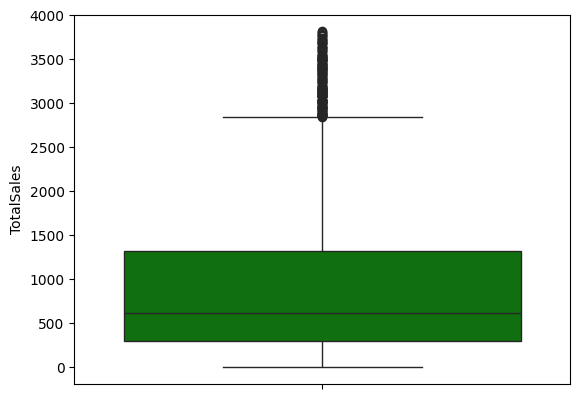

In [25]:
sns.boxplot(data=df_no_outliers["TotalSales"],color="green") #not perfect but ok 

<Axes: ylabel='TotalSales'>

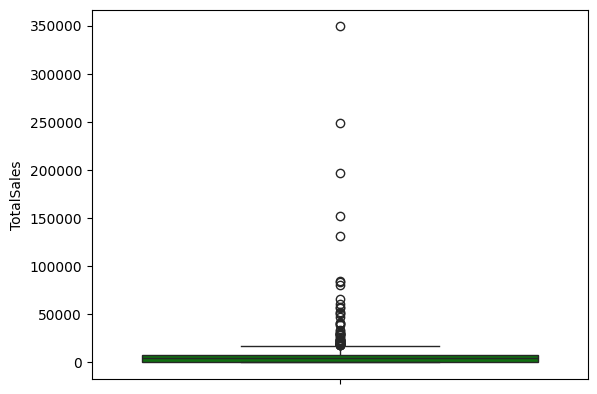

In [26]:
sns.boxplot(data=df_outliers["TotalSales"],color="green") 

/tmp/ipykernel_3129/1999653513.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df_no_outliers["TotalSales"], df_no_outliers["Invoice"], df_no_outliers["RecentActivity"], cmap='viridis', marker='o')


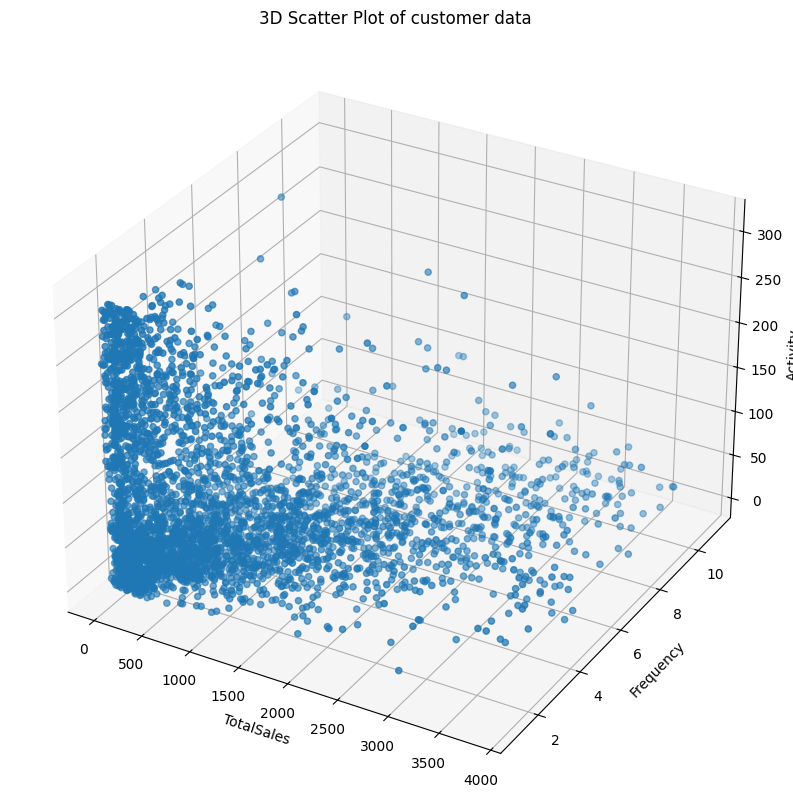

In [32]:
# Create a 3D scatter plot with Seaborn
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_no_outliers["TotalSales"], df_no_outliers["Invoice"], df_no_outliers["RecentActivity"], cmap='viridis', marker='o')
ax.set_xlabel('TotalSales')
ax.set_ylabel('Frequency')
ax.set_zlabel('Activity')
plt.title('3D Scatter Plot of customer data')
plt.show()

In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_outliers[["TotalSales","Invoice","RecentActivity"]])
k = scaler.transform(scaled_data)
standard_df = pd.DataFrame(k,columns=["TotalSales","Invoice","RecentActivity"])

/home/oskar/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [44]:
standard_df

,TotalSales,Invoice,RecentActivity
Customer ID,,,
12346.0,-1.106100,-1.489564,-1.014318
12347.0,-1.104429,-1.489564,-1.037469
12348.0,-1.106024,-1.686024,-1.027323
12349.0,-1.102478,-1.293105,-1.031753
12351.0,-1.105909,-1.686024,-1.036326
...,...,...,...
18283.0,-1.105416,-0.703725,-1.035326
18284.0,-1.105677,-1.686024,-1.028323
18285.0,-1.105727,-1.686024,-0.995596


/tmp/ipykernel_3129/2038849570.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(standard_df["TotalSales"], standard_df["Invoice"], standard_df["RecentActivity"], cmap='viridis', marker='o')


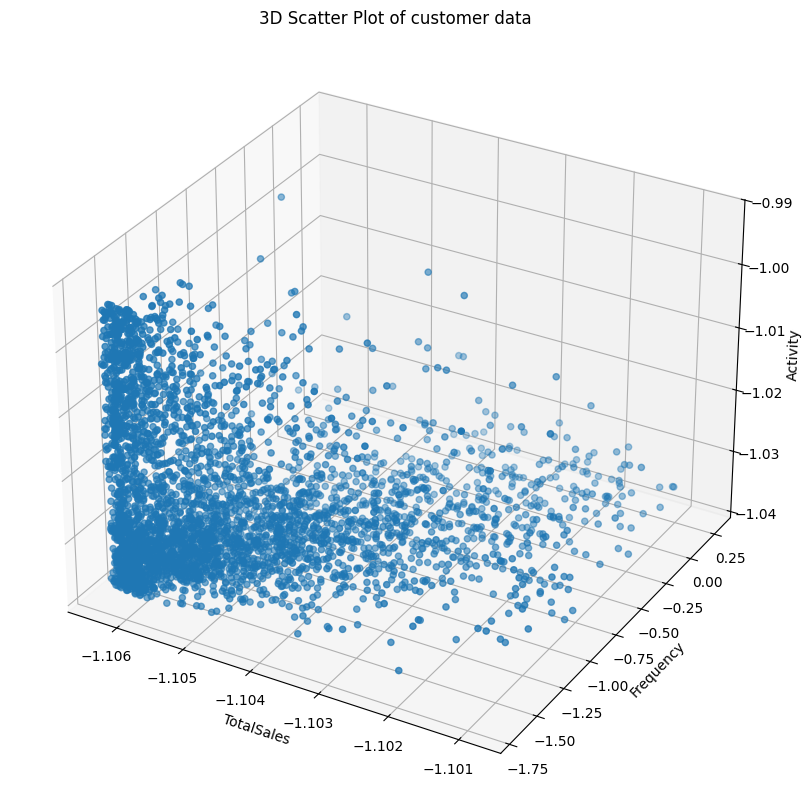

In [45]:
# Create a 3D scatter plot with Seaborn
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(standard_df["TotalSales"], standard_df["Invoice"], standard_df["RecentActivity"], cmap='viridis', marker='o')
ax.set_xlabel('TotalSales')
ax.set_ylabel('Frequency')
ax.set_zlabel('Activity')
plt.title('3D Scatter Plot of customer data')
plt.show()

In [47]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_no_outliers[["TotalSales", "Invoice", "RecentActivity"]])
standard_df = pd.DataFrame(scaled_data, columns=["TotalSales", "Invoice", "RecentActivity"])


In [48]:
standard_df

,TotalSales,Invoice,RecentActivity
0,0.043980,0.1,0.525641
1,0.346409,0.1,0.006410
2,0.057817,0.0,0.233974
3,0.699646,0.2,0.134615
4,0.078461,0.0,0.032051
...,...,...,...
3647,0.167789,0.5,0.054487
3648,0.120591,0.0,0.211538
3649,0.111502,0.0,0.945513
3650,0.339362,0.1,0.355769


/tmp/ipykernel_3129/1444537692.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(standard_df["TotalSales"], standard_df["Invoice"], standard_df["RecentActivity"], cmap='viridis', marker='o')


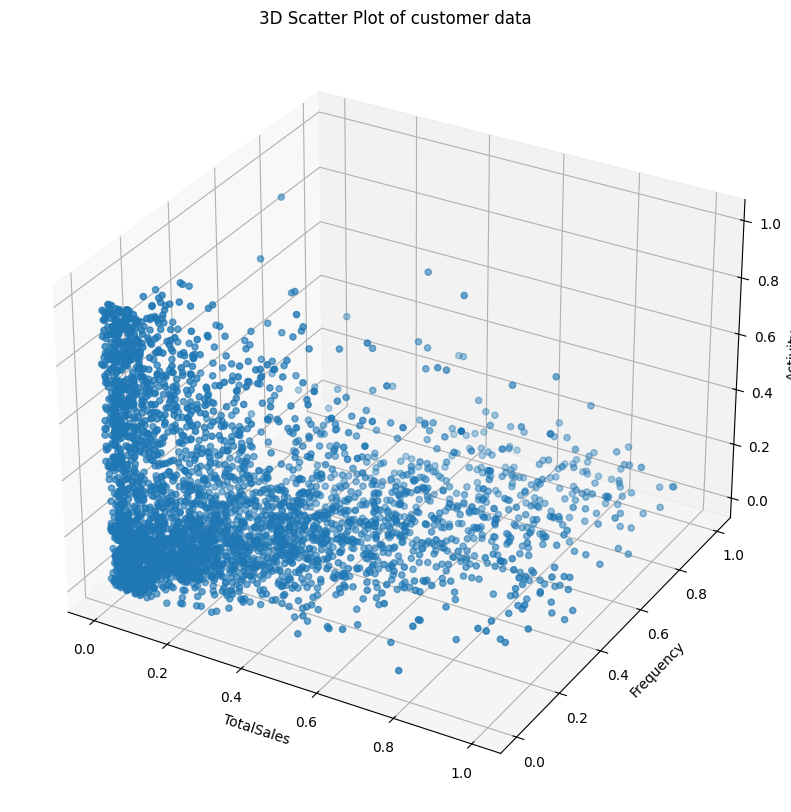

In [49]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(standard_df["TotalSales"], standard_df["Invoice"], standard_df["RecentActivity"], cmap='viridis', marker='o')
ax.set_xlabel('TotalSales')
ax.set_ylabel('Frequency')
ax.set_zlabel('Activity')
plt.title('3D Scatter Plot of customer data')
plt.show()

In [50]:
# I've tested two standarization formulas, the MinMax and StandardScaler
# But I will choose the MinMax cuz it's easier to work with and looks better. 

# Grouping the clients using k-mean clastering

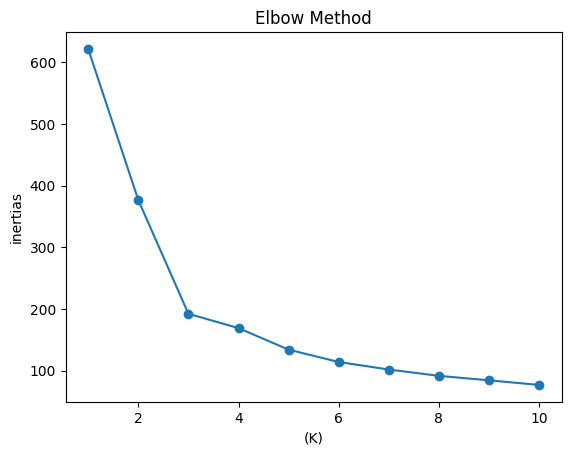

In [54]:
# Elbow method 


inertias = []
K_values = range(1, 11)  

for k in K_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit_predict(standard_df)
    inertias.append(kmeans.inertia_)  

plt.plot(K_values, inertias, marker='o')
plt.xlabel('(K)')
plt.ylabel('inertias')
plt.title('Elbow Method')
plt.show()


In [55]:
kmean = KMeans(n_clusters=3,random_state=42,max_iter=600)
cluster_labels = kmean.fit_predict(standard_df)
cluster_labels

array([0, 1, 1, ..., 0, 1, 2], dtype=int32)

In [56]:
standard_df["Cluster"] = cluster_labels

In [57]:
standard_df

,TotalSales,Invoice,RecentActivity,Cluster
0,0.043980,0.1,0.525641,0
1,0.346409,0.1,0.006410,1
2,0.057817,0.0,0.233974,1
3,0.699646,0.2,0.134615,2
4,0.078461,0.0,0.032051,1
...,...,...,...,...
3647,0.167789,0.5,0.054487,2
3648,0.120591,0.0,0.211538,1
3649,0.111502,0.0,0.945513,0
3650,0.339362,0.1,0.355769,1


/tmp/ipykernel_3129/4128074424.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(standard_df["TotalSales"], standard_df["Invoice"], standard_df["RecentActivity"], cmap='viridis',c=color, marker='o')


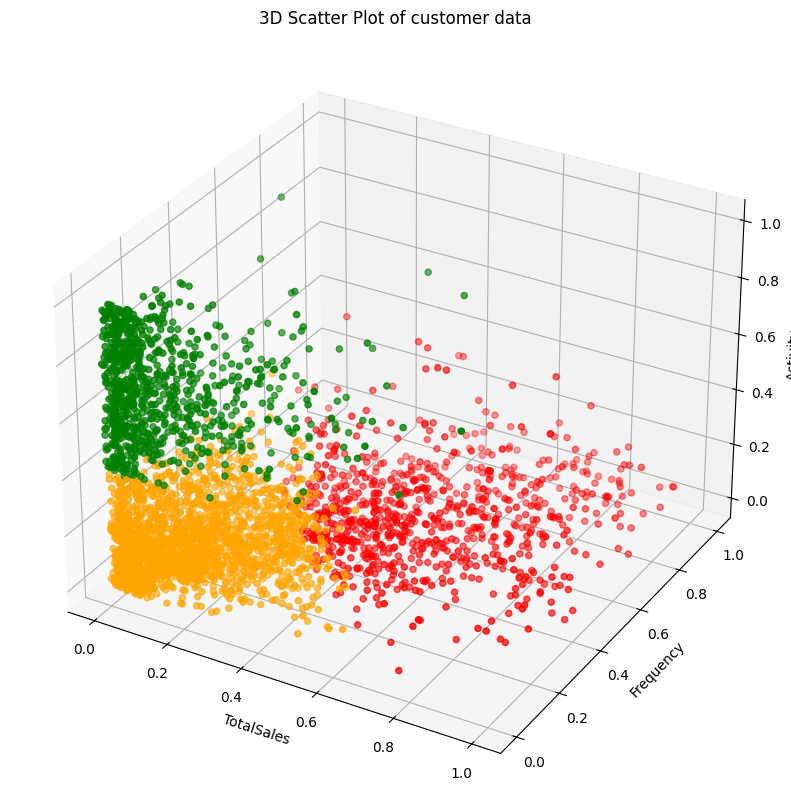

In [63]:
colors = {2:"red",1:"orange",0:"green"}
color = standard_df["Cluster"].map(colors)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(standard_df["TotalSales"], standard_df["Invoice"], standard_df["RecentActivity"], cmap='viridis',c=color, marker='o')
ax.set_xlabel('TotalSales')
ax.set_ylabel('Frequency')
ax.set_zlabel('Activity')
plt.title('3D Scatter Plot of customer data')
plt.show()

In [65]:
standard_df["Cluster"].value_counts()

Cluster
1    1958
0     864
2     830
Name: count, dtype: int64